# Objective
To build a deep learning model to differentiate an X-ray image of a normal person from an unhealthy one and subsequently build an app using Streamlit for users to make predictions or inference using your model.

# Data Description
This dataset contains training set images of 3 classes which are converted into numpy arrays.
The dataset comprises 3 classes:
1. COVID-19: The patient who is affected due to covid.
2. Viral Pneumonia: This is a viral fever that has similar characteristics to Covid but is not covid.
3. Normal- A healthy Person.

The data file names are:
- CovidImages.npy
- CovidLabels.csv
Due to the large volume of data, the images were converted to the CovidImages.npy file and the labels are also put into CovidLabels.

## **Importing the necessary packages**

In [1]:
import os
import numpy as np                                                                               # Importing numpy for Matrix Operations
import pandas as pd                                                                              # Importing pandas to read CSV files
import matplotlib.pyplot as plt                                                                  # Importting matplotlib for Plotting and visualizing images
import math                                                                                      # Importing math module to perform mathematical operations
import cv2                                                                                       # Importing openCV for image processing
import seaborn as sns                                                                            # Importing seaborn to plot graphs


# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator                              # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential                                                   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam,SGD                                                 # Importing the optimizers which can be used in our model
from sklearn import preprocessing                                                                # Importing the preprocessing module to preprocess the data
from sklearn.model_selection import train_test_split                                             # Importing train_test_split function to split the data into train and test
from sklearn.metrics import confusion_matrix                                                     # Importing confusion_matrix to plot the confusion matrix

# Display images using OpenCV
from google.colab.patches import cv2_imshow                                                      # Importing cv2_imshow from google.patches to display images

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# using tensorflow==2.14.0
#!pip install tensorflow==2.14.0

In [3]:
print(tf.__version__)

2.14.0


# Reading the data

In [4]:
# Mount Google drive to access the covid dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Load the image file of dataset
images = np.load('/content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/CovidImages.npy')

# Load the labels file of dataset
labels = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/CovidLabels.csv')

## **Overview of the dataset**


Let's print the shape of the images and labels

In [6]:
print(images.shape)
print(labels.shape)

(251, 128, 128, 3)
(251, 1)


There are 251 images of shape 128 x 128 X 3 each

## **Exploratory Data Analysis**

In [7]:
# names of the unique classes in the covid data?
labels["Label"].unique()

array(['Viral Pneumonia', 'Covid', 'Normal'], dtype=object)

In [8]:
# number of unique classes in the covid data?
labels["Label"].nunique()

3

# visualization of images

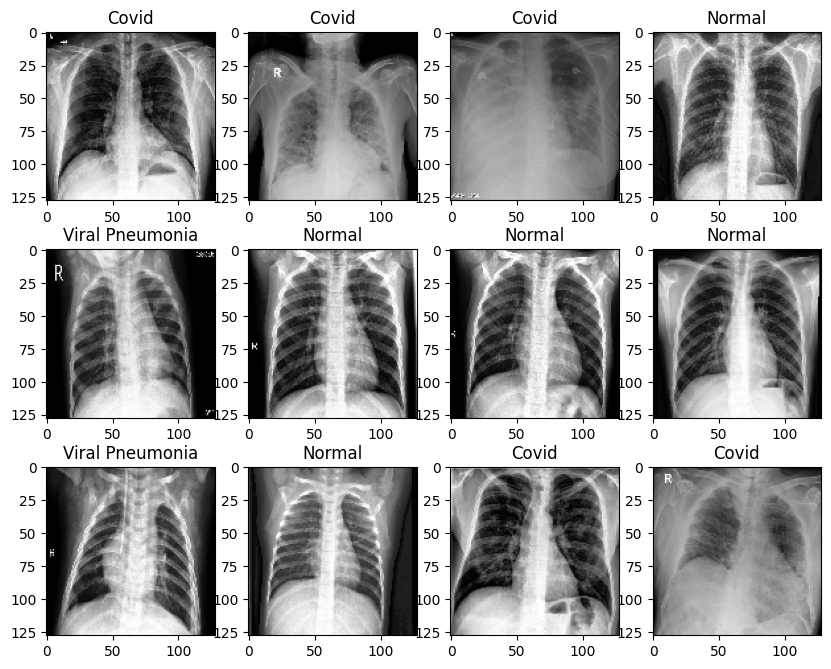

In [9]:
def plot_images(images,labels):
  num_classes=10                                                                  # Number of Classes
  categories=np.unique(labels)
  keys=dict(labels['Label'])                                                      # Obtaing the unique classes from y_train
  rows = 3                                                                        # Defining number of rows=3
  cols = 4                                                                        # Defining number of columns=4
  fig = plt.figure(figsize=(10, 8))                                               # Defining the figure size to 10x8
  for i in range(cols):
      for j in range(rows):
          random_index = np.random.randint(0, len(labels))                        # Generating random indices from the data and plotting the images
          ax = fig.add_subplot(rows, cols, i * rows + j + 1)                      # Adding subplots with 3 rows and 4 columns
          ax.imshow(images[random_index, :])                                      # Plotting the image
          ax.set_title(keys[random_index])
  plt.show()

plot_images(images,labels)

## Checking of data imbalance


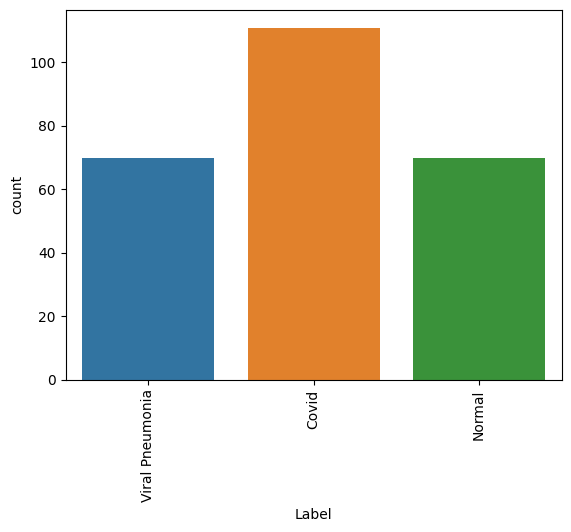

In [10]:
sns.countplot(x ='Label', data = labels)
plt.xticks(rotation=90);

In [11]:
labels['Label'].value_counts(normalize=True)

Covid              0.442231
Viral Pneumonia    0.278884
Normal             0.278884
Name: Label, dtype: float64

In [12]:
labels['Label'].value_counts(normalize=False)

Covid              111
Viral Pneumonia     70
Normal              70
Name: Label, dtype: int64

-   The data is imbalanced. The covid class has 31 additonal images. Data augmentation will be performed to increase the seize of the data abd address data imbalance

In [13]:
#covid = labels[labels['Label'] == 'Covid']

In [14]:
# Randomly select 70 samples from the 'Covid' class
#reduced_covid = covid.sample(n=70, random_state=42)
#reduced_covid


In [15]:
# Replace the original 'Covid' samples with the reduced set
#labels.loc[labels['Label'] == 'Covid'] = reduced_covid

In [16]:
#labels['Label'].value_counts(normalize=False)

In [17]:
#sns.countplot(x ='Label', data = labels)
#plt.xticks(rotation=90);

### Resizing images
As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [18]:
resized_images=[]
height = 64
width = 64
dimensions = (width, height)
for i in range(len(images)):
  resized_images.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

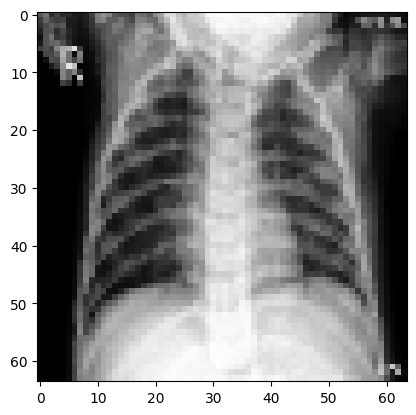

In [19]:
# show one image
plt.imshow(resized_images[8]);

In [20]:
# # check for missing values

# # Convert the list of images into a NumPy array
# images_array = np.array(images_decreased)

# # Flatten the 4D NumPy array into a 2D array
# images_flattened = images_array.reshape(images_array.shape[0], -1)

# # Convert the 2D array to a DataFrame
# images_decreased_df = pd.DataFrame(images_flattened)

# mv= images_decreased_df.isnull().sum()

In [21]:
# # Handle missing values by dropping rows with NaN
# labels = labels.dropna()

## Splitting of images

In [22]:
from sklearn.model_selection import train_test_split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(resized_images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)


In [23]:
len(X_train)

202

In [24]:
X_train.shape

(202, 64, 64, 3)

In [25]:
y_train.shape

(202, 1)

In [26]:
X_test.shape

(26, 64, 64, 3)

In [27]:
X_val.shape

(23, 64, 64, 3)

## Encoding the target labels

In [28]:
# Convert labels from names to one hot vectors.
# We have already used encoding methods like onehotencoder and labelencoder earlier so now we will be using a new encoding method called labelBinarizer.
# Labelbinarizer works similar to onehotencoder

from sklearn.preprocessing import LabelBinarizer
enc = LabelBinarizer()
y_train_encoded = enc.fit_transform(y_train)
y_val_encoded=enc.transform(y_val)
y_test_encoded=enc.transform(y_test)

## Data Normalization & Augmentation
Since the **image pixel values range from 0-255**, our method of normalization here will be **scaling** - we shall **divide all the pixel values by 255 to standardize the images to have values between 0-1.**

In [29]:
train_datagen = ImageDataGenerator(
                              rotation_range=180,
                              fill_mode='nearest',
                              horizontal_flip = True,
                              vertical_flip = True,
                              shear_range = 0.2,
                              zoom_range = 0.2
                              )
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0

# Model Development

## Transfer Learning using VGG16


- We will be using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

In [30]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [31]:
from tensorflow.keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [32]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.14.0


In [33]:
model_filepath = "/content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/covid_vgg_model.h5"
chkpt = ModelCheckpoint(model_filepath, verbose = 1, save_best_only=True)
es = EarlyStopping(patience=3, verbose = 1)

In [34]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))   # Importing the VGG16 Model with pretrained ImageNet weights
vgg_model.summary()                                                                   # Summary of the VGG16 Model without the dense layers

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [35]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [36]:
model = Sequential()

# Adding the convolutional part of the VGG16 model from above
model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model.add(Flatten())

# Adding a dense layer
model.add(Dense(32, activation='relu'))
# Adding droput layer with 0.2 dropout rate
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
# Adding the output layer with 12 neurons
model.add(Dense(3, activation='softmax'))
opt=Adam()
# Compile model
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [43]:
# Epochs
epochs = 10
# Batch size
batch_size = 64
# Fit the model with augmented data
history_vgg16 = model.fit(X_train_normalized,y_train_encoded, batch_size=batch_size, shuffle=False,
                          epochs=epochs,
                          validation_split=0.2,
                          verbose=1, callbacks = [es, chkpt])

Epoch 1/10
3/3 [==============================] - ETA: 0s - loss: 0.3980 - accuracy: 0.8820
Epoch 1: val_loss improved from 0.48057 to 0.43852, saving model to /content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/covid_vgg_model.h5
3/3 [==============================] - 10s 4s/step - loss: 0.3980 - accuracy: 0.8820 - val_loss: 0.4385 - val_accuracy: 0.9024
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 0.3631 - accuracy: 0.9255
Epoch 2: val_loss improved from 0.43852 to 0.39814, saving model to /content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/covid_vgg_model.h5
3/3 [==============================] - 11s 3s/step - loss: 0.3631 - accuracy: 0.9255 - val_loss: 0.3981 - val_accuracy: 0.9024
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 0.3414 - accuracy: 0.9255
Epoch 3: val_loss improved from 0.39814 to 0.36896, saving model to /content/drive/MyDrive/DATA SCIENCE/Aileadtech/MLOps/covid_vgg_model.h5
3/3 [==============================] - 14s 6s/step

### Plotting the Epoch vs Accuracy & Loss curve

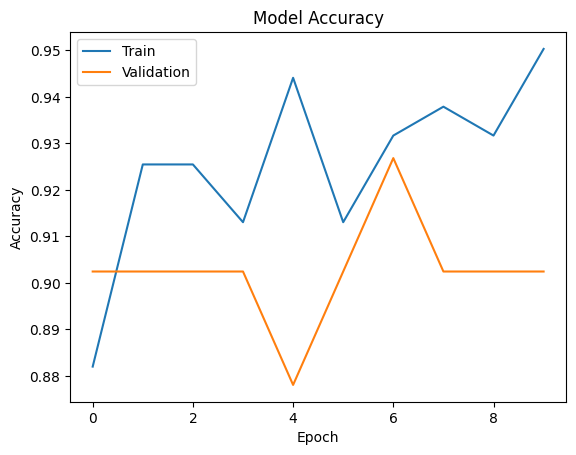

In [44]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Observations
- We can observe that there is an improvement in the accuracy of the VGG16 model as the epochs progressed. Interestingly, the validation accuracy slightly surpassed the training accuracy, suggesting that the model exhibited good generalization."

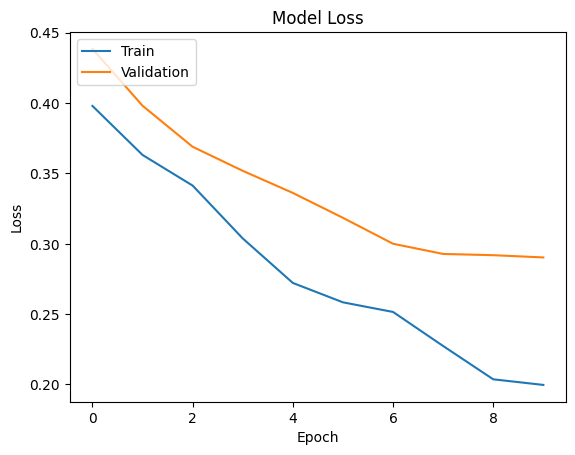

In [45]:
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

- - we can observe that the loss value reduced progressively across the epochs indicating that the model has significantly captured intricate patterns form the images

### Accuracy of the VGG16 Model

In [46]:
# Getting the accuracy of the model
accuracy = model.evaluate(X_test_normalized, y_test_encoded, verbose=2)

1/1 - 1s - loss: 0.1809 - accuracy: 0.9231 - 1s/epoch - 1s/step


In [47]:
# Here we would get the output as probablities for each category
y_pred=model.predict(X_test_normalized)

1/1 [==============================] - 1s 1s/step


# Model Evaluation

## Confusion Matrix

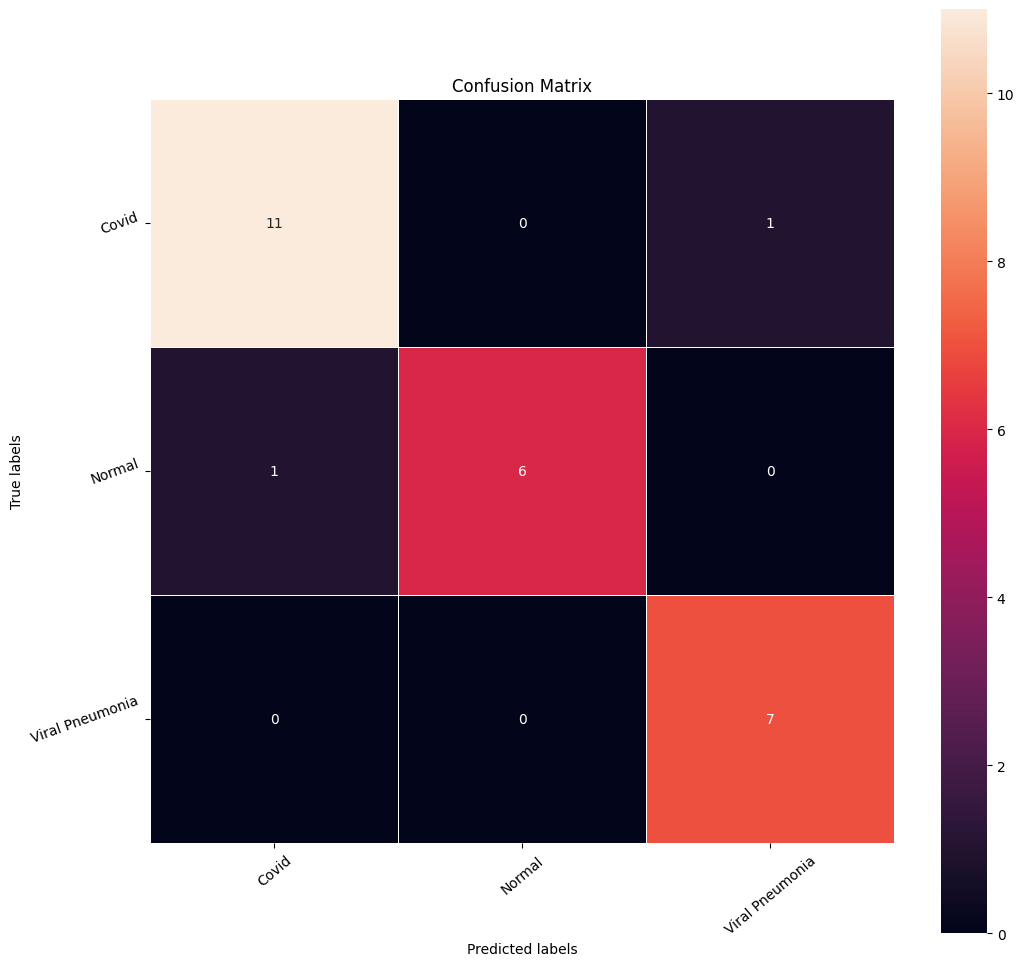

In [48]:
# Obtaining the categorical values from y_test_encoded and y_pred
y_pred_arg=np.argmax(y_pred,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined in tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred_arg)
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
# Setting the labels to both the axes
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(list(enc.classes_),rotation=40)
ax.yaxis.set_ticklabels(list(enc.classes_),rotation=20)
plt.show()

- The model has made just two errors in the test data: one image labeled as normal, was incorrectly predicted as a COVID image, and another COVID image was mistakenly classified as having viral pneumonia."